/Users/sarvesh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


0               624
1               625
2               626
3               627
4               628
             ...   
12794622    1725894
12794623    5681778
12794624    6395326
12794625    4926899
12794626    7656685
Name: Unnamed: 0, Length: 12794627, dtype: int64

0              192.168.4.118-203.73.24.75-4504-80-6
1              192.168.4.118-203.73.24.75-4504-80-6
2              192.168.4.118-203.73.24.75-4505-80-6
3              192.168.4.118-203.73.24.75-4505-80-6
4              192.168.4.118-203.73.24.75-4506-80-6
                             ...                   
12794622     172.31.67.50-209.85.203.113-53598-80-6
12794623     172.31.69.17-108.174.10.14-54599-443-6
12794624        172.31.0.2-172.31.65.49-53-61087-17
12794625        172.31.0.2-172.31.67.58-53-61580-17
12794626    169.254.169.254-172.31.65.89-80-49393-6
Name: Flow ID, Length: 12794627, dtype: object

0            192.168.4.118
1            192.168.4.118
2            192.168.4.118
3            192.168.4.118
4 

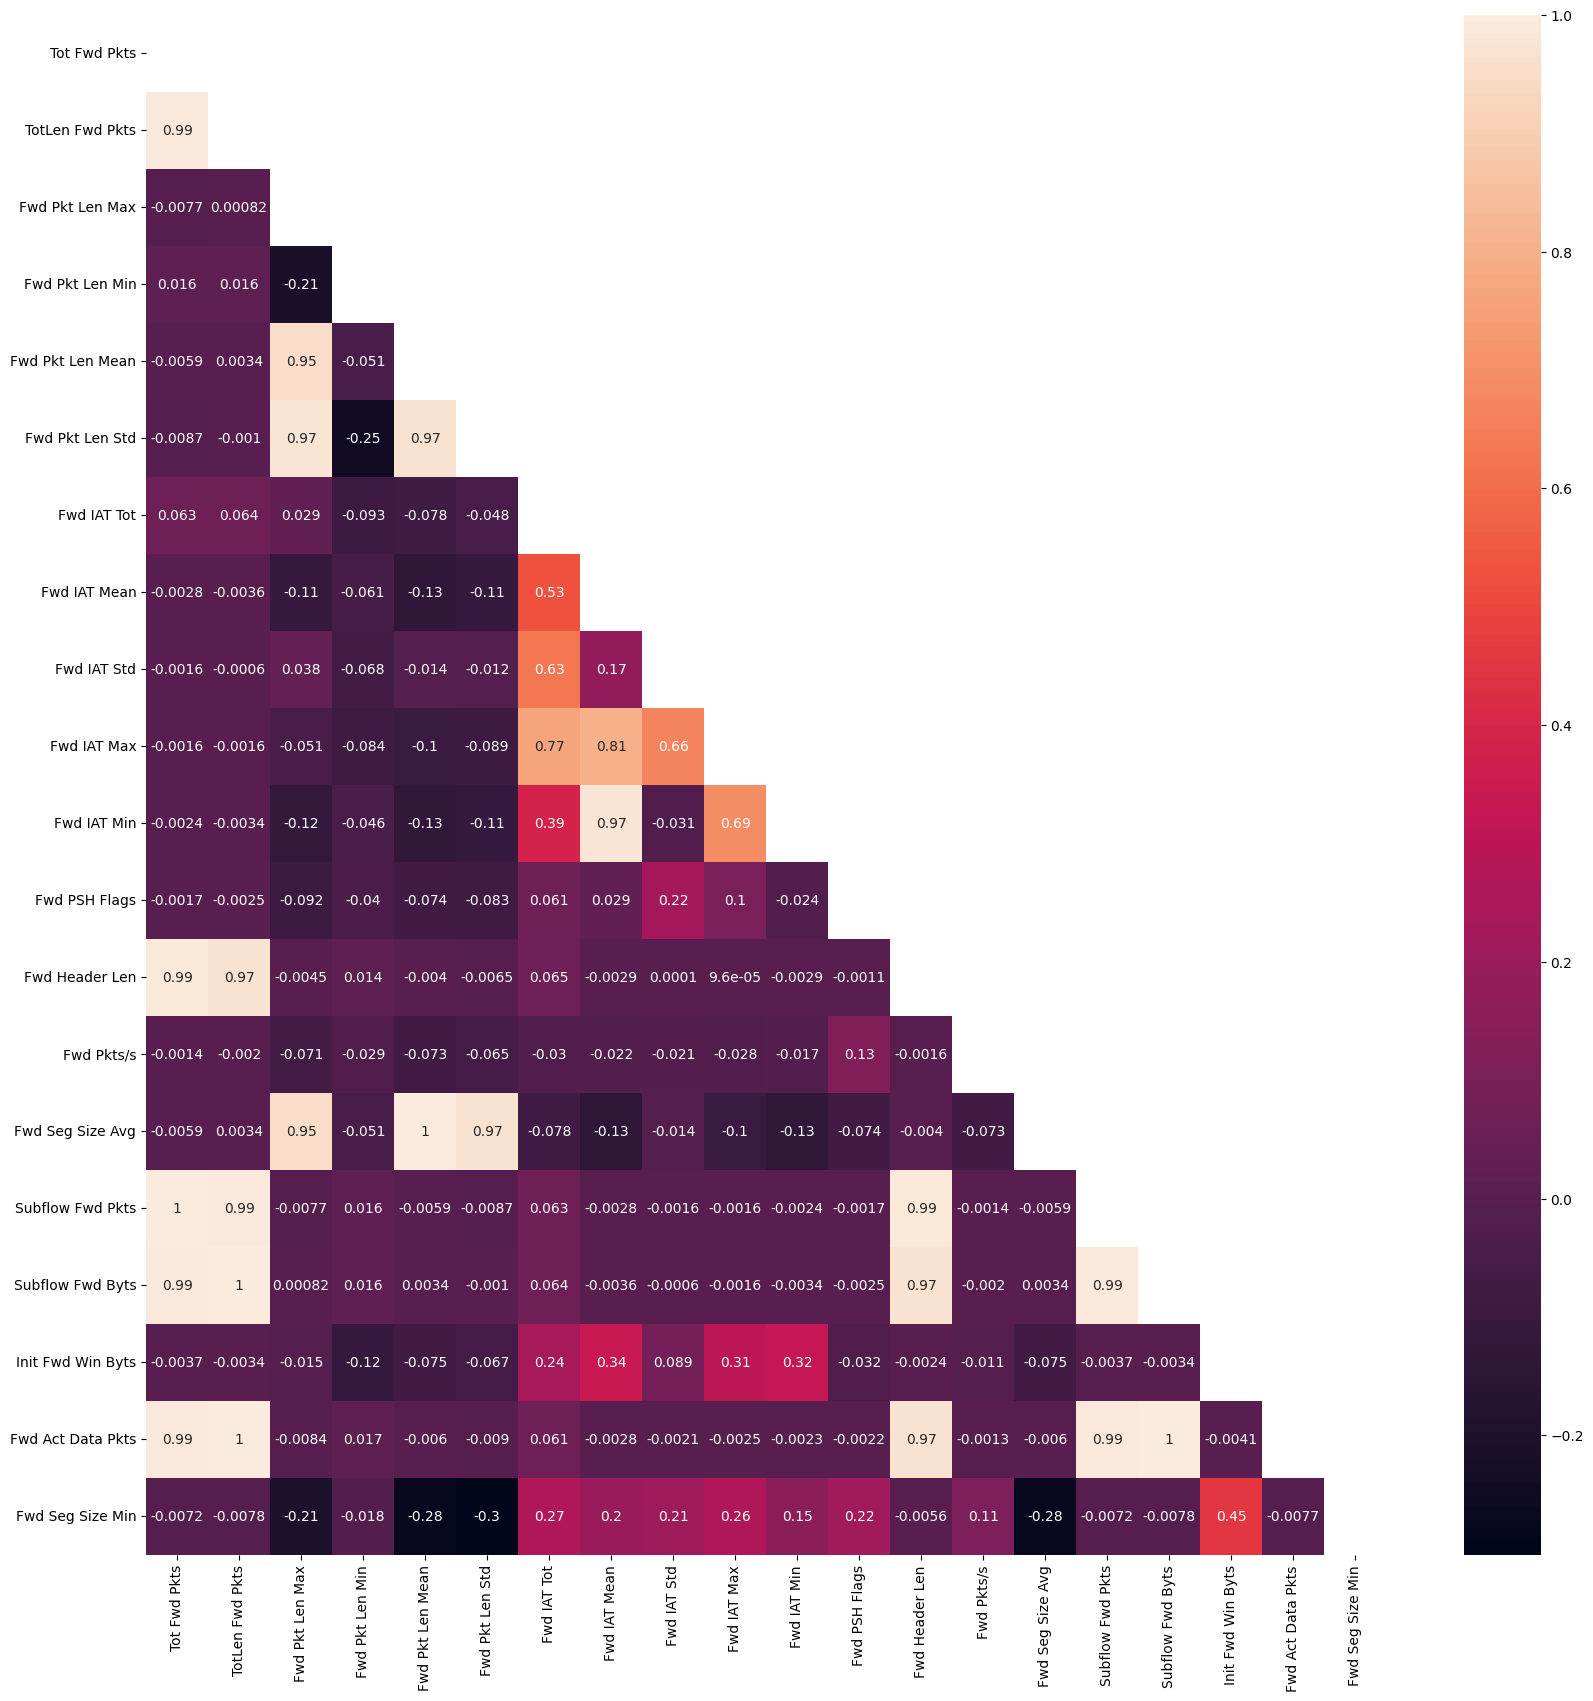

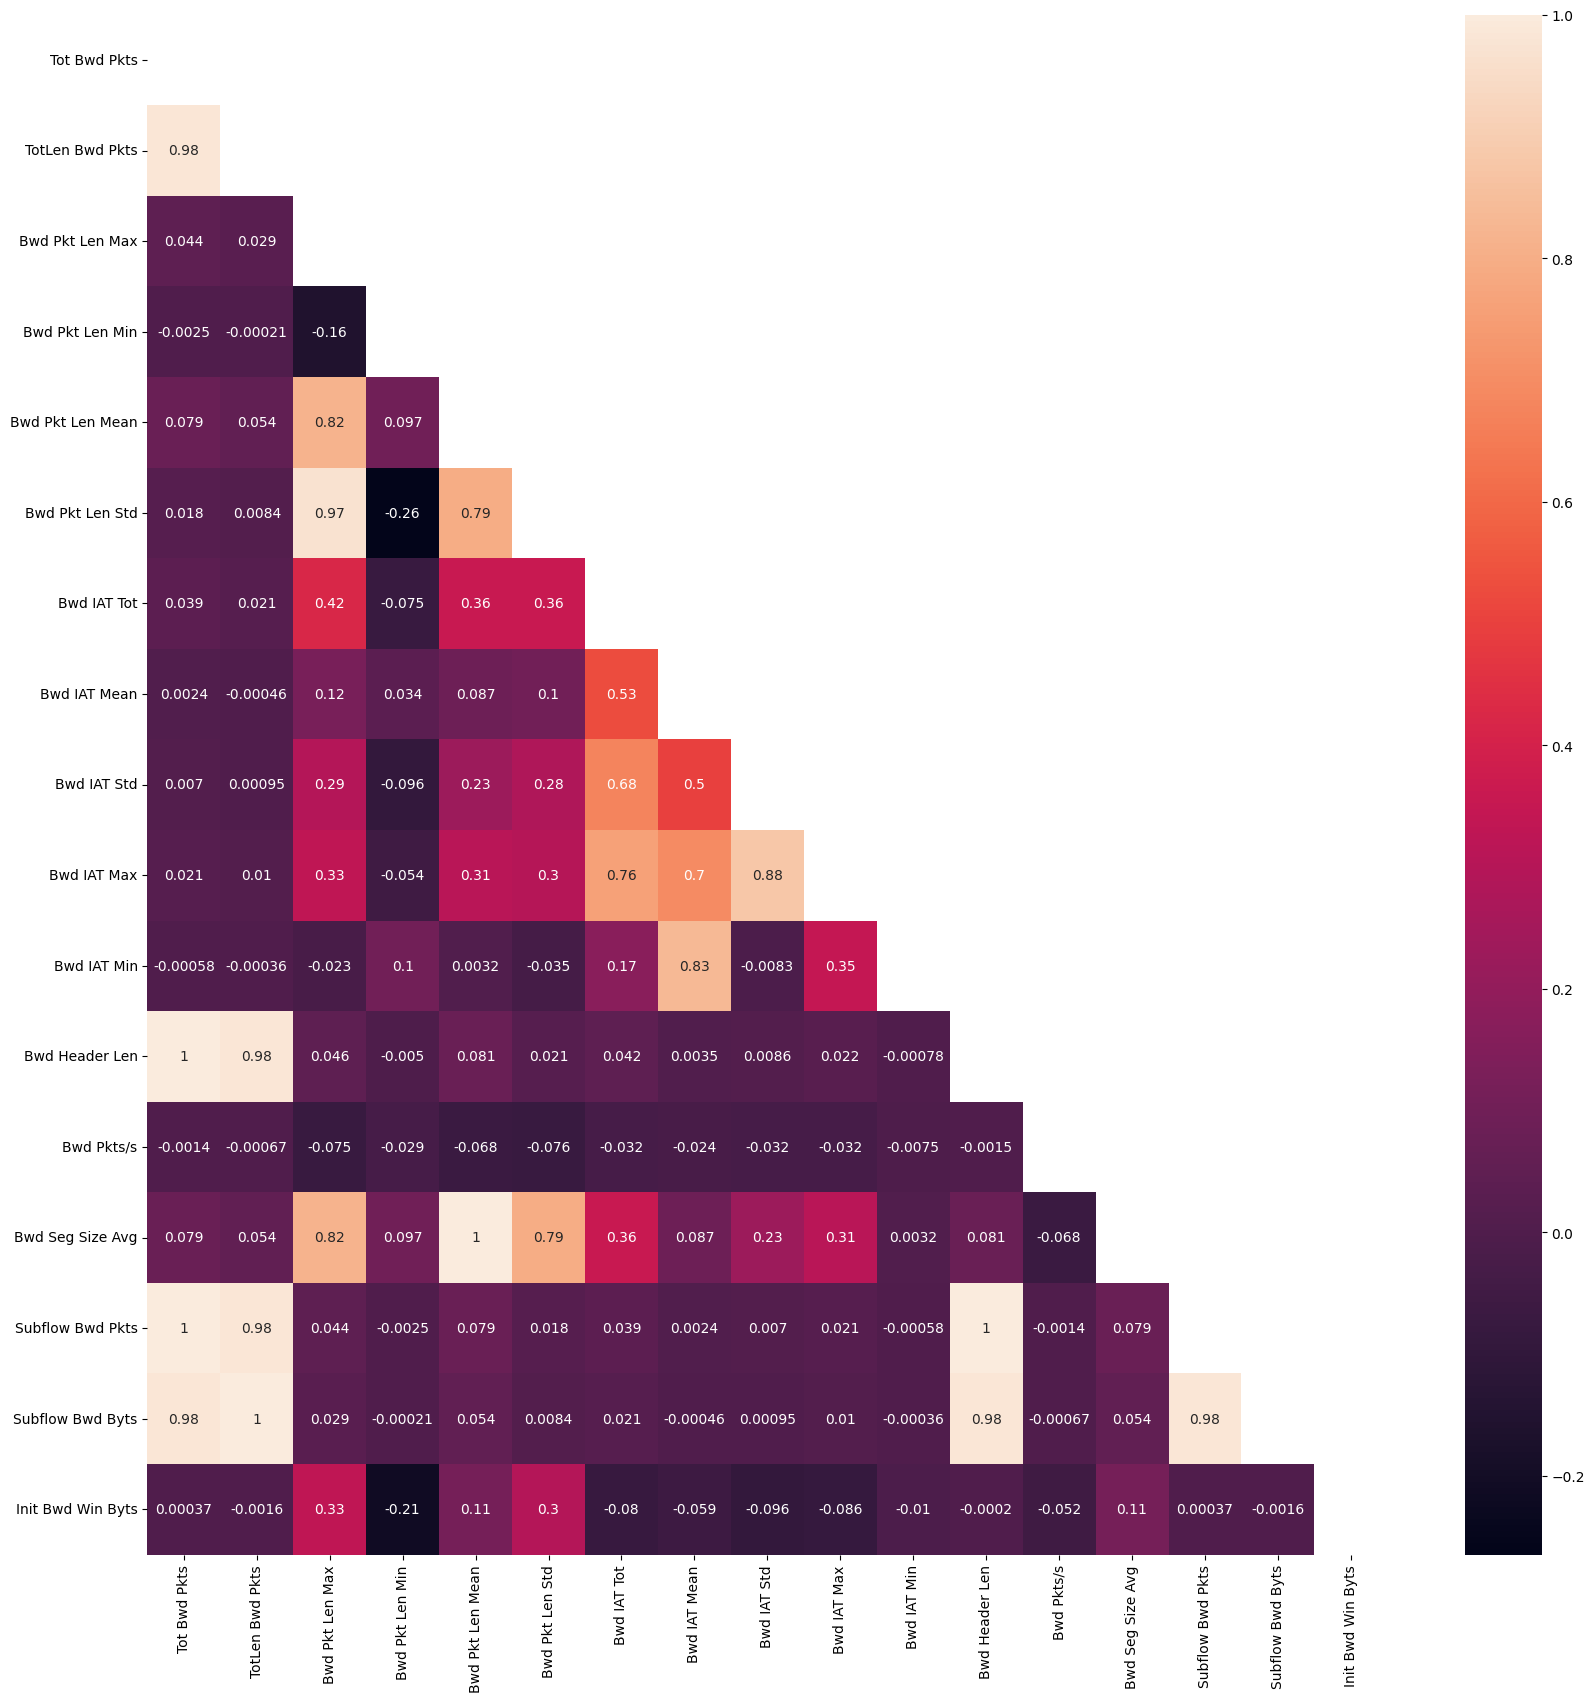

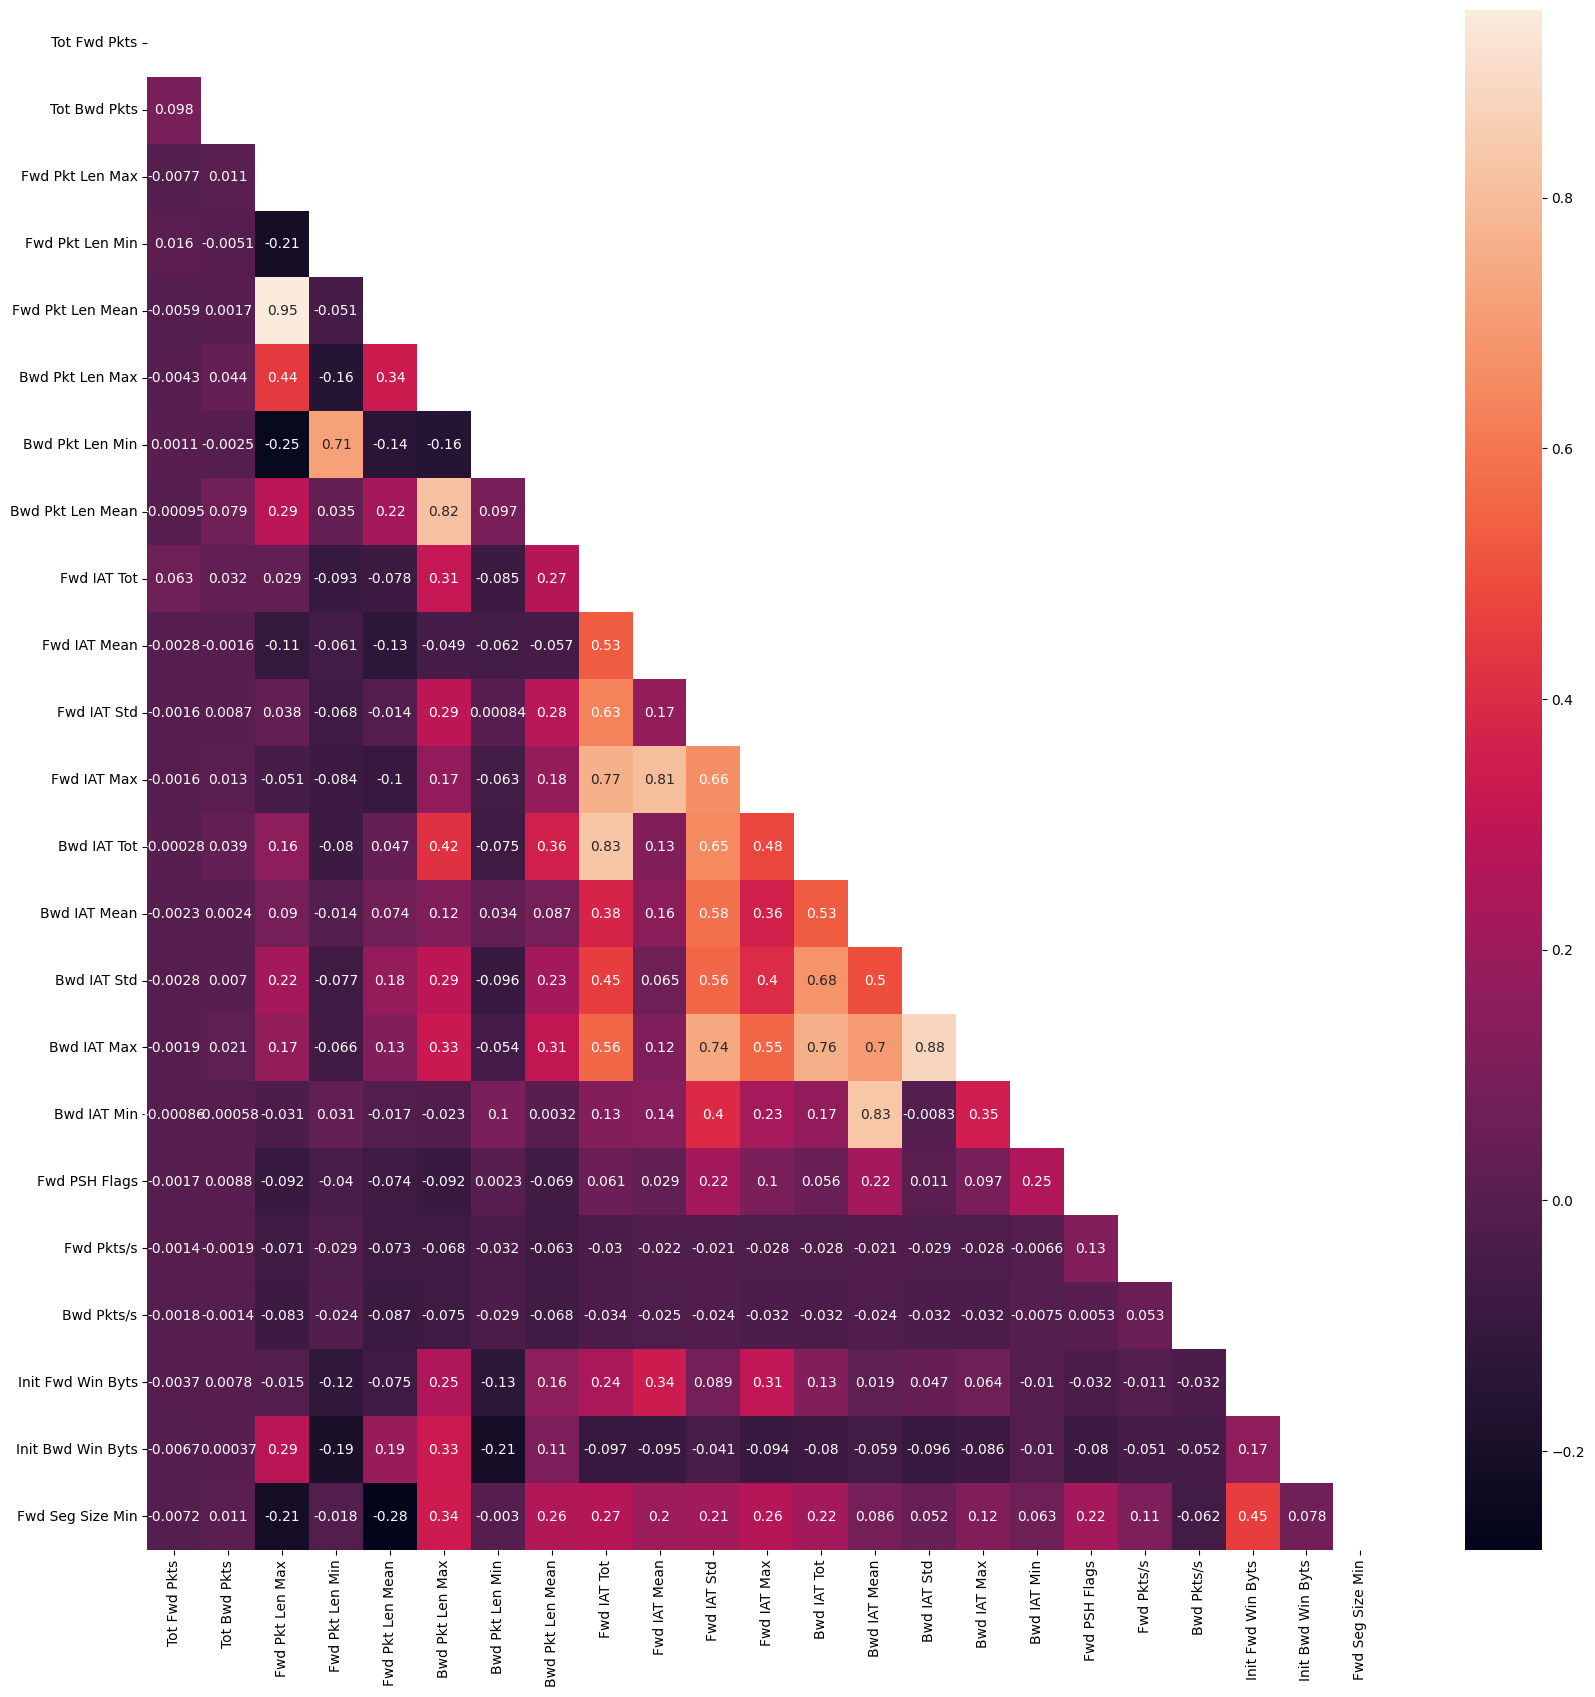

In [2]:
import tensorflow as tf
from tensorflow import keras
import psutil
import numpy as np 
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
import os
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
import gc
file_path='../data-science-template/data/raw/final_dataset.csv'
df=pd.read_csv(file_path)
df.drop_duplicates(inplace=True)
df.head()
for column in df.columns:
    print(df[column])
    print()

num_rows = len(df)
for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    if top_pct > 0.98:
        print('{0}: {1:.2f}%'.format(col, top_pct*100))
        print(cnts)
        print()

colsToDrop = np.array(['Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags','FIN Flag Cnt','URG Flag Cnt','Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg'])
missing = df.isna().sum()
missing = pd.DataFrame({'count': missing, '% of total': missing/len(df)*100}, index=df.columns)
print(missing)
colsToDrop = np.union1d(colsToDrop, missing[missing['% of total'] >= 50].index.values)
dropnaCols = missing[(missing['% of total'] > 0) & (missing['% of total'] <= 5)].index.values
df['Flow Byts/s'].replace(np.inf, np.nan, inplace=True)
df['Flow Pkts/s'].replace(np.inf, np.nan, inplace=True)
dropnaCols = np.union1d(dropnaCols, ['Flow Byts/s', 'Flow Pkts/s'])
df.drop(columns=colsToDrop, inplace=True)
df.dropna(subset=dropnaCols, inplace=True)
gc.collect()
del colsToDrop
del dropnaCols
gc.collect()
#feature selection

num_cols =  df.select_dtypes(exclude=['object']).columns
fwd_cols = [col for col in num_cols if 'Fwd' in col]
bwd_cols = [col for col in num_cols if 'Bwd' in col]
def getCorrelatedFeatures(corr):
    correlatedFeatures = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if (abs(corr.iloc[i, j])) > 0.95:
                print(corr.columns[i],corr.iloc[i,j])
                correlatedFeatures.add(corr.columns[i])
    return correlatedFeatures

corr = df[fwd_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
from IPython.display import display
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score,ConfusionMatrixDisplay
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True, mask=mask)
correlatedFeatures = set()
correlatedFeatures = correlatedFeatures | getCorrelatedFeatures(corr)
correlatedFeatures
corr = df[bwd_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
plt.subplots(figsize=(20,20))
sns.heatmap(corr,annot=True, mask=mask)
correlatedFeatures = correlatedFeatures | getCorrelatedFeatures(corr)
correlatedFeatures
df.drop(columns=correlatedFeatures, inplace=True)
del num_cols
del fwd_cols 
del bwd_cols
gc.collect()
num_cols = df.select_dtypes(exclude=['object']).columns
cols = [col for col in num_cols if 'Fwd' in col or 'Bwd' in col]
corr = df[cols].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True, mask=mask)
correlatedFeatures = correlatedFeatures | getCorrelatedFeatures(corr)
correlatedFeatures
df.drop(columns=getCorrelatedFeatures(corr), inplace=True)
del num_cols
del cols
del corr
gc.collect()
df.shape
from sklearn import preprocessing 
for f in df.columns: 
    if df[f].dtype=='object': 
        label = preprocessing.LabelEncoder() 
        label.fit(list(df[f].values)) 
        df[f] = label.transform(list(df[f].values))

print(df.info())
mb = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(mb))
df=df.astype('float32')
mb = df.memory_usage().sum() / 1024**2
print('Memory usage of dataframe is {:.2f} MB'.format(mb))
Y = df['Label']
X = df.drop("Label",axis=1)
print(df.shape)
print(X.shape)
print(Y.shape)
# Assume df is your DataFrame
# For demonstration purposes, let's assume 'target_column' is the column you want to predict (your target variable).

test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
print(X_train.shape[1])
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
model.fit(X_train, Y_train, epochs=18, batch_size=20000, validation_split=0.2)

Epoch 1/18
408/408 [==============================] - 19s 46ms/step - loss: 28866.6445 - accuracy: 0.9401 - val_loss: 2261.9998 - val_accuracy: 0.9888
Epoch 2/18
408/408 [==============================] - 21s 52ms/step - loss: 1974.3010 - accuracy: 0.9852 - val_loss: 657.2152 - val_accuracy: 0.9957
Epoch 3/18
408/408 [==============================] - 19s 46ms/step - loss: 674.9747 - accuracy: 0.9925 - val_loss: 231.7998 - val_accuracy: 0.9973
Epoch 4/18
408/408 [==============================] - 19s 45ms/step - loss: 320.0521 - accuracy: 0.9940 - val_loss: 135.2218 - val_accuracy: 0.9970
Epoch 5/18
408/408 [==============================] - 18s 45ms/step - loss: 165.2430 - accuracy: 0.9941 - val_loss: 72.8498 - val_accuracy: 0.9971
Epoch 6/18
408/408 [==============================] - 19s 47ms/step - loss: 100.2219 - accuracy: 0.9941 - val_loss: 53.2171 - val_accuracy: 0.9957
Epoch 7/18
408/408 [==============================] - 19s 45ms/step - loss: 62.8607 - accuracy: 0.9942 - val_l

In [7]:
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])



model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=18, batch_size=20000, validation_split=0.2)

Epoch 1/18
408/408 [==============================] - 18s 43ms/step - loss: 21530.2500 - accuracy: 0.9383 - val_loss: 1069.1542 - val_accuracy: 0.9878
Epoch 2/18
408/408 [==============================] - 18s 44ms/step - loss: 1083.6532 - accuracy: 0.9827 - val_loss: 261.3251 - val_accuracy: 0.9955
Epoch 3/18
408/408 [==============================] - 18s 43ms/step - loss: 360.4865 - accuracy: 0.9903 - val_loss: 73.8229 - val_accuracy: 0.9962
Epoch 4/18
408/408 [==============================] - 18s 43ms/step - loss: 178.2300 - accuracy: 0.9923 - val_loss: 44.9190 - val_accuracy: 0.9972
Epoch 5/18
408/408 [==============================] - 17s 43ms/step - loss: 100.5766 - accuracy: 0.9930 - val_loss: 59.4341 - val_accuracy: 0.9975
Epoch 6/18
408/408 [==============================] - 18s 43ms/step - loss: 58.0909 - accuracy: 0.9934 - val_loss: 25.0456 - val_accuracy: 0.9971
Epoch 7/18
408/408 [==============================] - 19s 46ms/step - loss: 41.9306 - accuracy: 0.9937 - val_loss

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

79668/79668 [==============================] - 33s 407us/step - loss: 0.0374 - accuracy: 0.9904
Test Loss: 0.03742837533354759
Test Accuracy: 0.9904121160507202
